Loading and preprocessing data...

Performing cohort analysis...


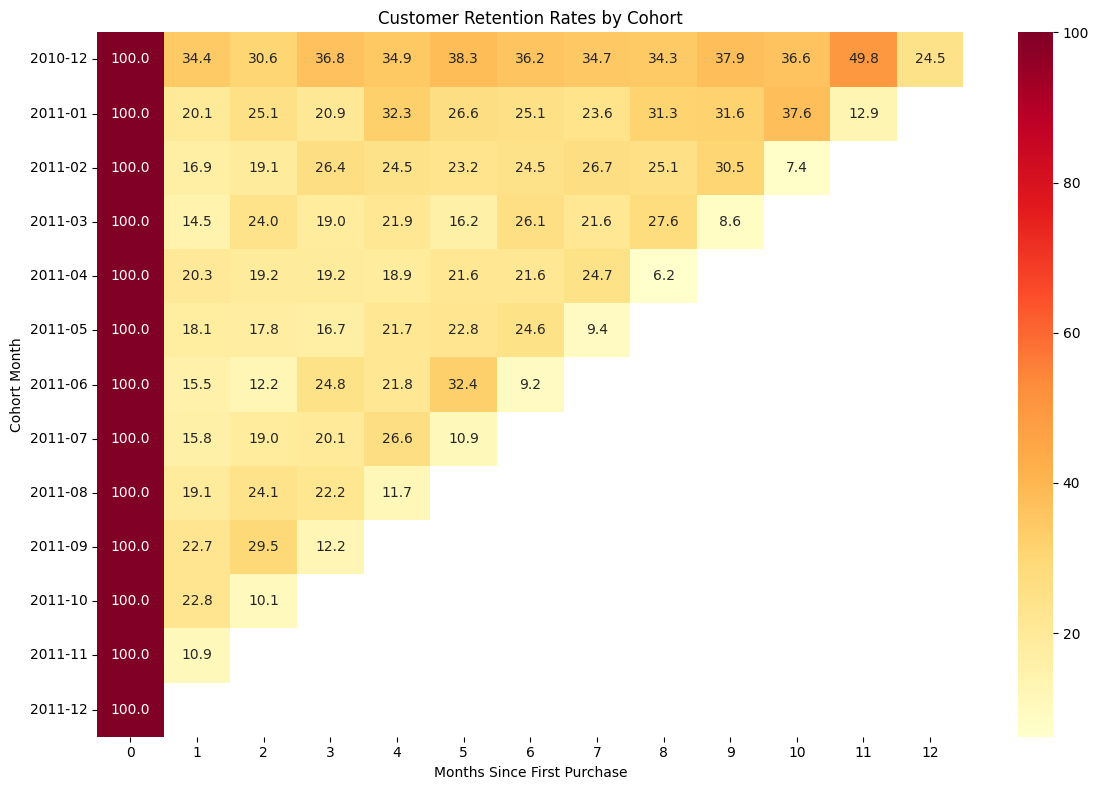


Performing RFM analysis...


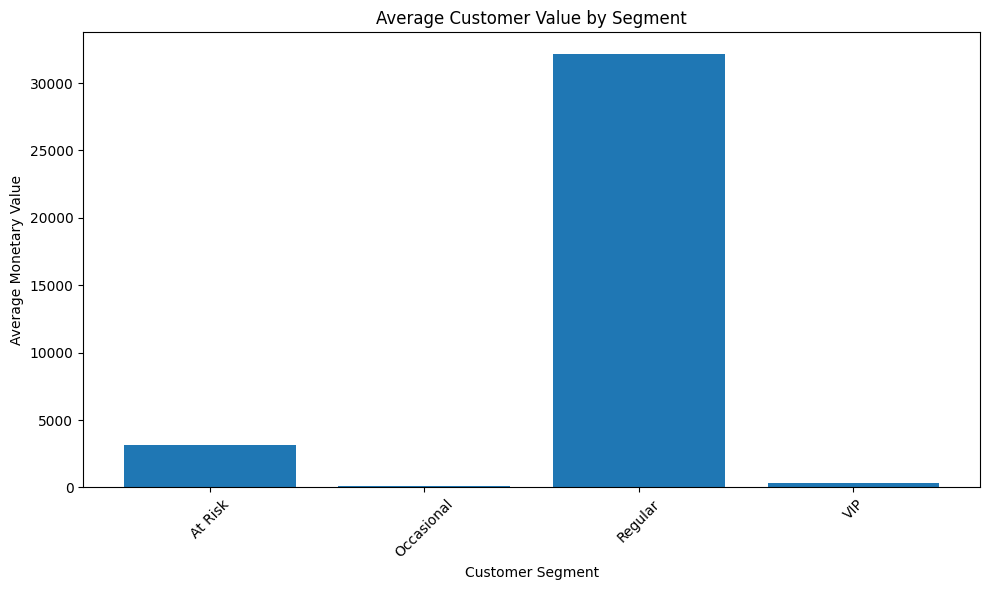

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jqnh5lb/78bpxvj5.json



Performing time series forecasting...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6jqnh5lb/4jb8sxgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8254', 'data', 'file=/tmp/tmp6jqnh5lb/78bpxvj5.json', 'init=/tmp/tmp6jqnh5lb/4jb8sxgc.json', 'output', 'file=/tmp/tmp6jqnh5lb/prophet_model_lhwe_kz/prophet_model-20241224151806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:18:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


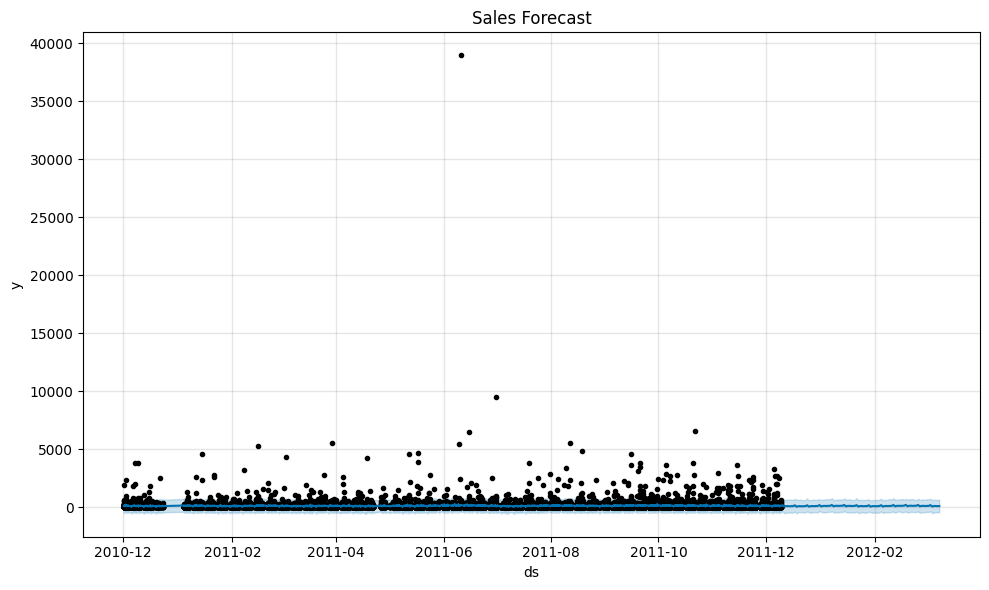


Calculating key metrics...

Performing market basket analysis...

Top 10 Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []

Key Business Insights:
Total Revenue: $2,162,603.96
Average Order Value: $134.87
Items per Order: 77.0
Customer Retention Rate: 63.5%
Total Unique Products: 3336


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import plotly.express as px
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    print("Loading and preprocessing data...")
    df = pd.read_csv(file_path)

    # Convert column names to match the dataset
    df.columns = ['CustomerID', 'InvoiceNo', 'ProductNo', 'Date', 'UnitPrice', 'Quantity']

    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Calculate revenue
    df['Revenue'] = df['UnitPrice'] * df['Quantity']

    # Remove duplicates and handle missing values
    df = df.drop_duplicates()
    df = df.dropna()

    # Remove negative quantities and prices (likely returns)
    df = df[df['Quantity'] > 0]
    df = df[df['UnitPrice'] > 0]

    return df

# 2. Cohort Analysis
def perform_cohort_analysis(df):
    print("\nPerforming cohort analysis...")

    # Create cohort groups based on first purchase date
    df['CohortDate'] = df.groupby('CustomerID')['Date'].transform('min').dt.to_period('M')
    df['TransactionMonth'] = df['Date'].dt.to_period('M')

    # Calculate cohort index
    def get_month_diff(x, y):
        return 12 * (x.year - y.year) + (x.month - y.month)

    df['CohortIndex'] = df.apply(lambda x: get_month_diff(x['TransactionMonth'].to_timestamp(),
                                                         x['CohortDate'].to_timestamp()), axis=1)

    # Calculate retention rates
    cohort_data = df.groupby(['CohortDate', 'CohortIndex'])['CustomerID'].nunique().reset_index()
    cohort_table = cohort_data.pivot(index='CohortDate', columns='CohortIndex', values='CustomerID')
    retention_rates = cohort_table.divide(cohort_table[0], axis=0) * 100

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(retention_rates.round(1), annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Customer Retention Rates by Cohort')
    plt.xlabel('Months Since First Purchase')
    plt.ylabel('Cohort Month')
    plt.tight_layout()
    plt.show()

    return retention_rates

# 3. RFM Analysis
def perform_rfm_analysis(df):
    print("\nPerforming RFM analysis...")

    # Calculate Recency, Frequency, Monetary
    today = df['Date'].max()
    rfm = df.groupby('CustomerID').agg({
        'Date': lambda x: (today - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'Revenue': 'sum'  # Monetary
    }).reset_index()

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    # Scale the RFM metrics
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

    # Perform clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

    # Map segment numbers to meaningful labels
    segment_labels = {
        0: 'VIP',
        1: 'Regular',
        2: 'Occasional',
        3: 'At Risk'
    }
    rfm['SegmentLabel'] = rfm['Segment'].map(segment_labels)

    # Plotting
    plt.figure(figsize=(10, 6))
    segment_stats = rfm.groupby('SegmentLabel').agg({
        'Monetary': 'mean',
        'CustomerID': 'count'
    }).reset_index()

    plt.bar(segment_stats['SegmentLabel'], segment_stats['Monetary'])
    plt.title('Average Customer Value by Segment')
    plt.xlabel('Customer Segment')
    plt.ylabel('Average Monetary Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return rfm

# 4. Time Series Forecasting
def perform_time_series_forecasting(df):
    print("\nPerforming time series forecasting...")

    # Prepare data for Prophet
    daily_sales = df.groupby('Date')['Revenue'].sum().reset_index()
    daily_sales.columns = ['ds', 'y']

    # Create and fit Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(daily_sales)

    # Make future predictions
    future_dates = model.make_future_dataframe(periods=90)  # 90 days forecast
    forecast = model.predict(future_dates)

    # Plotting
    fig = model.plot(forecast)
    plt.title('Sales Forecast')
    plt.tight_layout()
    plt.show()

    return forecast

# 5. Key Metrics Calculation
def calculate_key_metrics(df):
    print("\nCalculating key metrics...")

    metrics = {
        'total_revenue': df['Revenue'].sum(),
        'total_orders': df['InvoiceNo'].nunique(),
        'total_customers': df['CustomerID'].nunique(),
        'average_order_value': df['Revenue'].sum() / df['InvoiceNo'].nunique(),
        'items_per_order': df['Quantity'].sum() / df['InvoiceNo'].nunique(),
        'unique_products': df['ProductNo'].nunique()
    }

    # Calculate customer purchase frequency
    purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
    metrics['returning_customers'] = (purchase_frequency[purchase_frequency > 1].count() /
                                    metrics['total_customers'] * 100)

    return metrics

# 6. Market Basket Analysis using Apriori
def perform_market_basket_analysis(df):
    print("\nPerforming market basket analysis...")

    # Prepare transaction data
    basket = df.groupby(['InvoiceNo', 'ProductNo'])['Quantity'].sum().unstack().fillna(0)
    basket_encoded = (basket > 0).astype(int)

    # Generate frequent itemsets
    frequent_itemsets = apriori(basket_encoded, min_support=0.01, use_colnames=True)

    # Generate association rules with num_itemsets argument
    if not frequent_itemsets.empty:
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1, num_itemsets=2)
        rules = rules.sort_values('lift', ascending=False)

        # Display top 10 association rules
        print("\nTop 10 Association Rules:")
        print(rules.head(10))

        return rules.head(10)  # Return top 10 rules
    else:
        print("No frequent itemsets found with current support threshold")
        return pd.DataFrame()

def main():
    # Load and preprocess data
    df = load_and_preprocess_data('1_e-commerse.csv')

    # Perform all analyses
    retention_rates = perform_cohort_analysis(df)
    rfm_results = perform_rfm_analysis(df)
    sales_forecast = perform_time_series_forecasting(df)
    key_metrics = calculate_key_metrics(df)
    association_rules_result = perform_market_basket_analysis(df)

    # Print key insights
    print("\nKey Business Insights:")
    print(f"Total Revenue: ${key_metrics['total_revenue']:,.2f}")
    print(f"Average Order Value: ${key_metrics['average_order_value']:.2f}")
    print(f"Items per Order: {key_metrics['items_per_order']:.1f}")
    print(f"Customer Retention Rate: {key_metrics['returning_customers']:.1f}%")
    print(f"Total Unique Products: {key_metrics['unique_products']}")

    # Save results to CSV files
    rfm_results.to_csv('rfm_results.csv', index=False)
    if not association_rules_result.empty:
        association_rules_result.to_csv('association_rules.csv', index=False)

if __name__ == "__main__":
    main()
